In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
# the first flag below was False when we tested this script but True makes A100 training a lot faster:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
from collections import OrderedDict
from PIL import Image
from copy import deepcopy
from glob import glob
from time import time
import argparse
import logging
import os

from latent_token_models import DiT_models
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL

/home/dan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = argparse.ArgumentParser(description="Train a DiT model on CelebA")
args.model='NPDiT-S'
args.data_path = '/home/dan/data/celeba/img_align_celeba'
args.image_size = 32
args.num_classes = 1
args.num_channels = 3
args.global_batch_size = 16
args.global_seed = 42

model = DiT_models[args.model](
        num_classes=args.num_classes,
        in_channels=args.num_channels,
        num_tokens=args.image_size**2,
    ).to(device)
diffusion = create_diffusion(timestep_respacing="")  # default: 1000 steps, linear noise schedule

# Setup data:
def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    https://github.com/openai/guided-diffusion/blob/8fb3ad9197f16bbc40620447b2742e13458d2831/guided_diffusion/image_datasets.py#L126
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])


transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, args.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])
dataset = ImageFolder(args.data_path, transform=transform)
sampler = DistributedSampler(
    dataset,
    num_replicas=1,
    rank=0,
    shuffle=True,
    seed=args.global_seed
)
loader = DataLoader(
    dataset,
    batch_size=int(args.global_batch_size),
    shuffle=False,
    sampler=sampler,
    num_workers=1,
    pin_memory=True,
    drop_last=True
)
pixel_idx = torch.arange(args.image_size**2, device=device)  # Used to create coordinates for images



init2 100 384


In [42]:
# load checkpoint
checkpoint_path = 'results/fm-randctx068-NPDiT-S/checkpoints/0020000.pt'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model"], strict=False)
model.eval()

NP_DiT(
  (h_embedder): Linear(in_features=203, out_features=384, bias=True)
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(2, 384)
  )
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True

In [46]:
num_samples = 3
img = next(iter(loader))[0].to(device) # Get a batch of images
x1, x2 = pixel_idx//args.image_size, pixel_idx%args.image_size
pos = torch.stack([2*x1.float()/(args.image_size-1) - 1, 
                    2*x2.float()/(args.image_size-1) - 1], -1).to(img.device)[None].repeat(args.global_batch_size, 1, 1)
x = img.to(device).reshape(args.global_batch_size, args.num_channels, args.image_size*args.image_size).transpose(1, 2)

if True: # half image ctx
    ctx_idxs = torch.arange(0, args.image_size**2//2, device=device).unsqueeze(0).repeat(args.global_batch_size, 1) 
    model_kwargs = dict(pos=pos, ctx_pos=pos[:, ctx_idxs[0]], ctx_x=x[:, ctx_idxs[0]]) 
else:
    ctx_size = args.image_size**2 // 5
    ctx_idxs = torch.cuda.FloatTensor(args.global_batch_size, args.image_size**2).uniform_().argsort(-1)[...,:ctx_size].to(img.device)
    ctx_pos = pos[torch.arange(args.global_batch_size).unsqueeze(1), ctx_idxs]
    ctx_x = x[torch.arange(args.global_batch_size).unsqueeze(1), ctx_idxs]
    model_kwargs = dict(pos=pos, ctx_pos=ctx_pos, ctx_x=ctx_x)

all_samples = []
T = diffusion.num_timesteps
for s in range(num_samples):
    print(f"Generating samples {s+1}")
    x = torch.randn(args.global_batch_size, args.image_size**2, args.num_channels, device=device)   
    for t in range(T):
        with torch.no_grad():
            pred = model(x, torch.Tensor([T-t]*x.shape[0]).to(device), **model_kwargs)
        alpha = 1+t/T*(1-t/T)
        sigma = 0.2*(t/T*(1-t/T))**0.5
        x += (alpha*pred + sigma*torch.randn_like(x).to(x.device))/T        
    all_samples.append(x.cpu().numpy())

n = args.global_batch_size
w = args.image_size
c = args.num_channels


Generating samples 1
Generating samples 2
Generating samples 3


torch.Size([16, 3, 32, 32]) tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


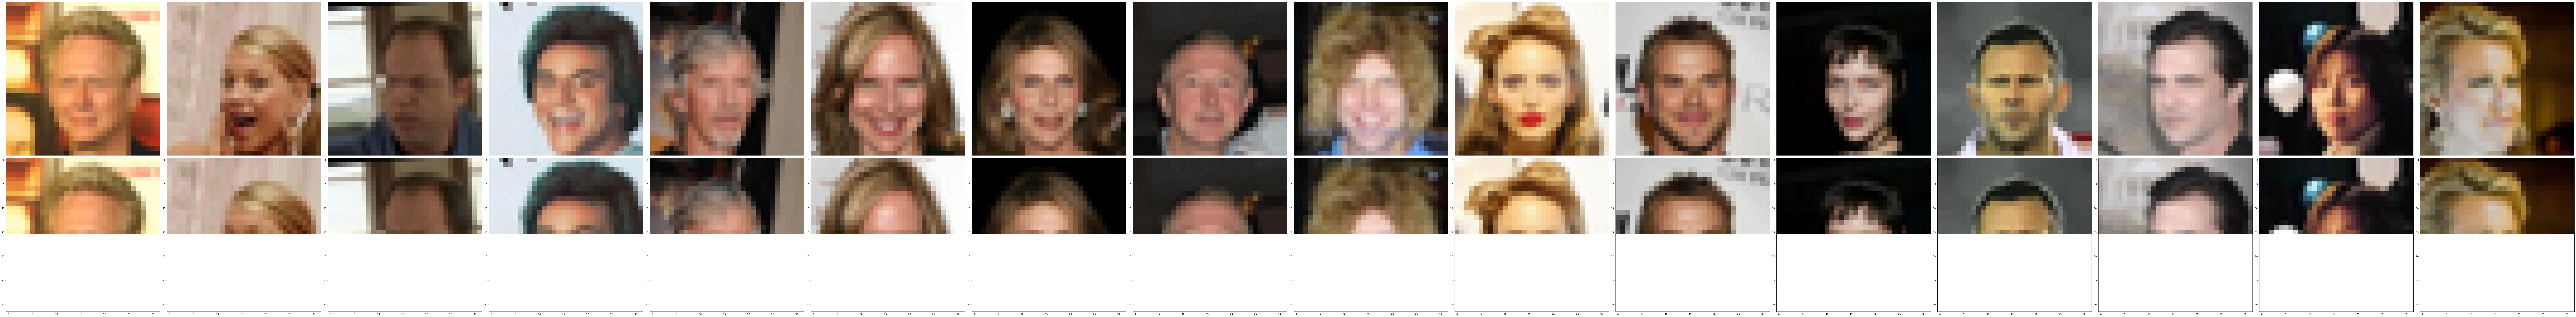

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06514922..1.1439344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0844723..1.0928134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009458005..1.0649953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06386006..1.1004152].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018962145..1.2979538].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.034988254..1.0329194].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0

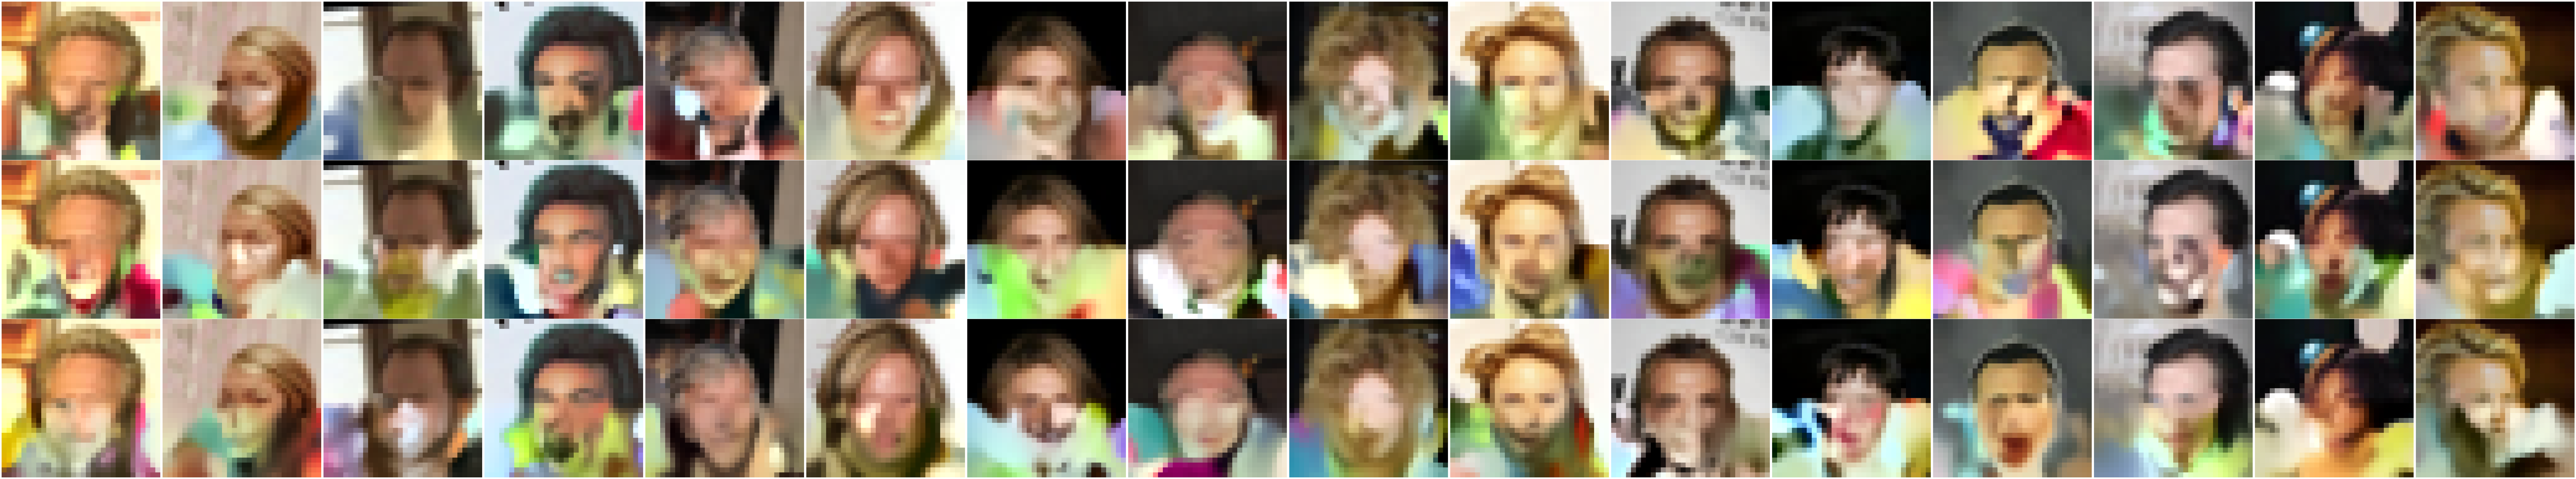

In [47]:
print(img.shape, torch.min(img), torch.max(img))
plt.figure(figsize=(10*n, 10*2))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow((img[i].permute(1, 2, 0).cpu().reshape(w, w, c)+1.)/2.)
    plt.axis('off')
    plt.subplot(2, n, n + i + 1)
    # mask out all pixels that are not in the context
    ctx_img = torch.ones((w*w, c), device=img.device)
    ctx_img[ctx_idxs[i]] = img[i].permute(1, 2, 0).reshape(w*w, c)[ctx_idxs[i]]
    plt.imshow((ctx_img.reshape(w, w, c).cpu()+1.)/2.)
    
plt.tight_layout()
plt.show()
plt.figure(figsize=(10*n, 10*num_samples))
for s in range(num_samples):
    for i in range(n):
        plt.subplot(num_samples, n, s * n + i + 1)
        plt.imshow((all_samples[s][i].reshape(w, w, c)+1.)/2.)
        plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
num_samples = 3
img = next(iter(loader))[0] .to(device) # Get a batch of images
x1, x2 = pixel_idx//args.image_size, pixel_idx%args.image_size
pos = torch.stack([2*x1.float()/(args.image_size-1) - 1, 
                    2*x2.float()/(args.image_size-1) - 1], -1).to(img.device)[None].repeat(args.global_batch_size, 1, 1)
x = img.to(device).reshape(args.global_batch_size, args.num_channels, args.image_size*args.image_size).transpose(1, 2)
ctx_idx = torch.arange(0, w*w//2, device=device)  # Use the first half of the pixels as context
model_kwargs = dict(pos=pos, ctx_pos=pos[:, ctx_idx], ctx_x=x[:, ctx_idx]) 
#loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
all_samples = []
for s in range(num_samples):
        z = torch.randn(args.global_batch_size, args.image_size**2, args.num_channels, device=device)
        samples = diffusion.p_sample_loop(
                model.forward, z.shape, z, clip_denoised=True, model_kwargs=model_kwargs, progress=True, device=device)
        all_samples.append(samples.cpu().numpy())

n = args.global_batch_size
w = args.image_size
c = args.num_channels

In [21]:
samples = np.load('results/fm0066-NPDiT-S/samples_0053000.npz')['samples']
#samples = np.load('samples_0130000.npz')['samples']
n = samples.shape[0]
w = int(np.sqrt(samples.shape[1]))
c = samples.shape[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3307277..2.6584105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6359591..2.020501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3327665..2.122335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5423877..2.3092277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.348735..2.1012247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93868196..2.2116568].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.864077..

-4.2719183 4.316821
-0.027463434 1.0157051


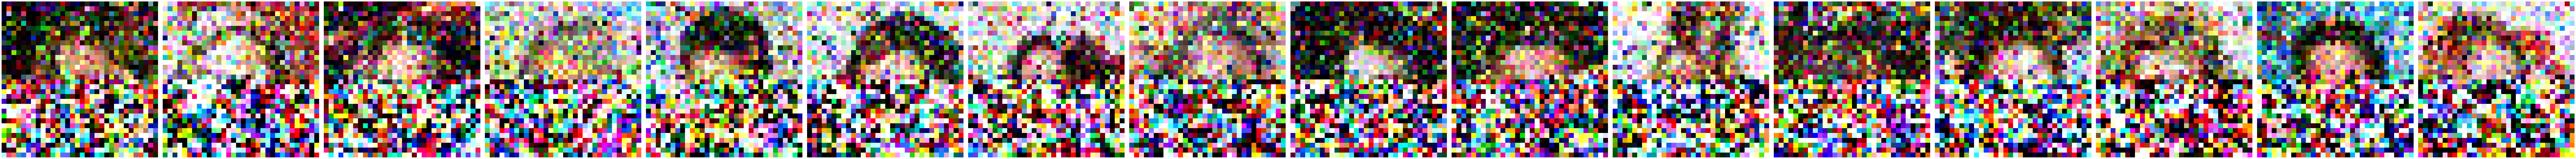

In [25]:
print(np.min(samples), np.max(samples))
print(np.mean(samples), np.std(samples))
plt.figure(figsize=(10*n, 10))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow((samples[i].reshape(w, w, c)+1.)/2.)
    plt.axis('off')
plt.tight_layout()
plt.show()